# Optimizing the design and operation of a two nodal energy system with networks
In this study, we want to look at a two-nodal system in a brownfield manner. We assume two fictous regions with a heat demand and an electricity demand and we want to study the decarbonization of these two regions and the required carbon tax associated with a certain emission reduction. First we will optimize the design and operation of the system without a carbon tax and then study the effect of a carbon tax. The topology of the energy system is depicted below. Brown rectancles mean that the technology is already installed, green retangles mean that the technology can be newly build. Both colors mean that the technology can be expanded.

We assume that there are two nodes: one depicting a city with no options to install wind turbines and no power plant and a rural node with a gas-fired power plant and the option to install wind turbines.

<div>
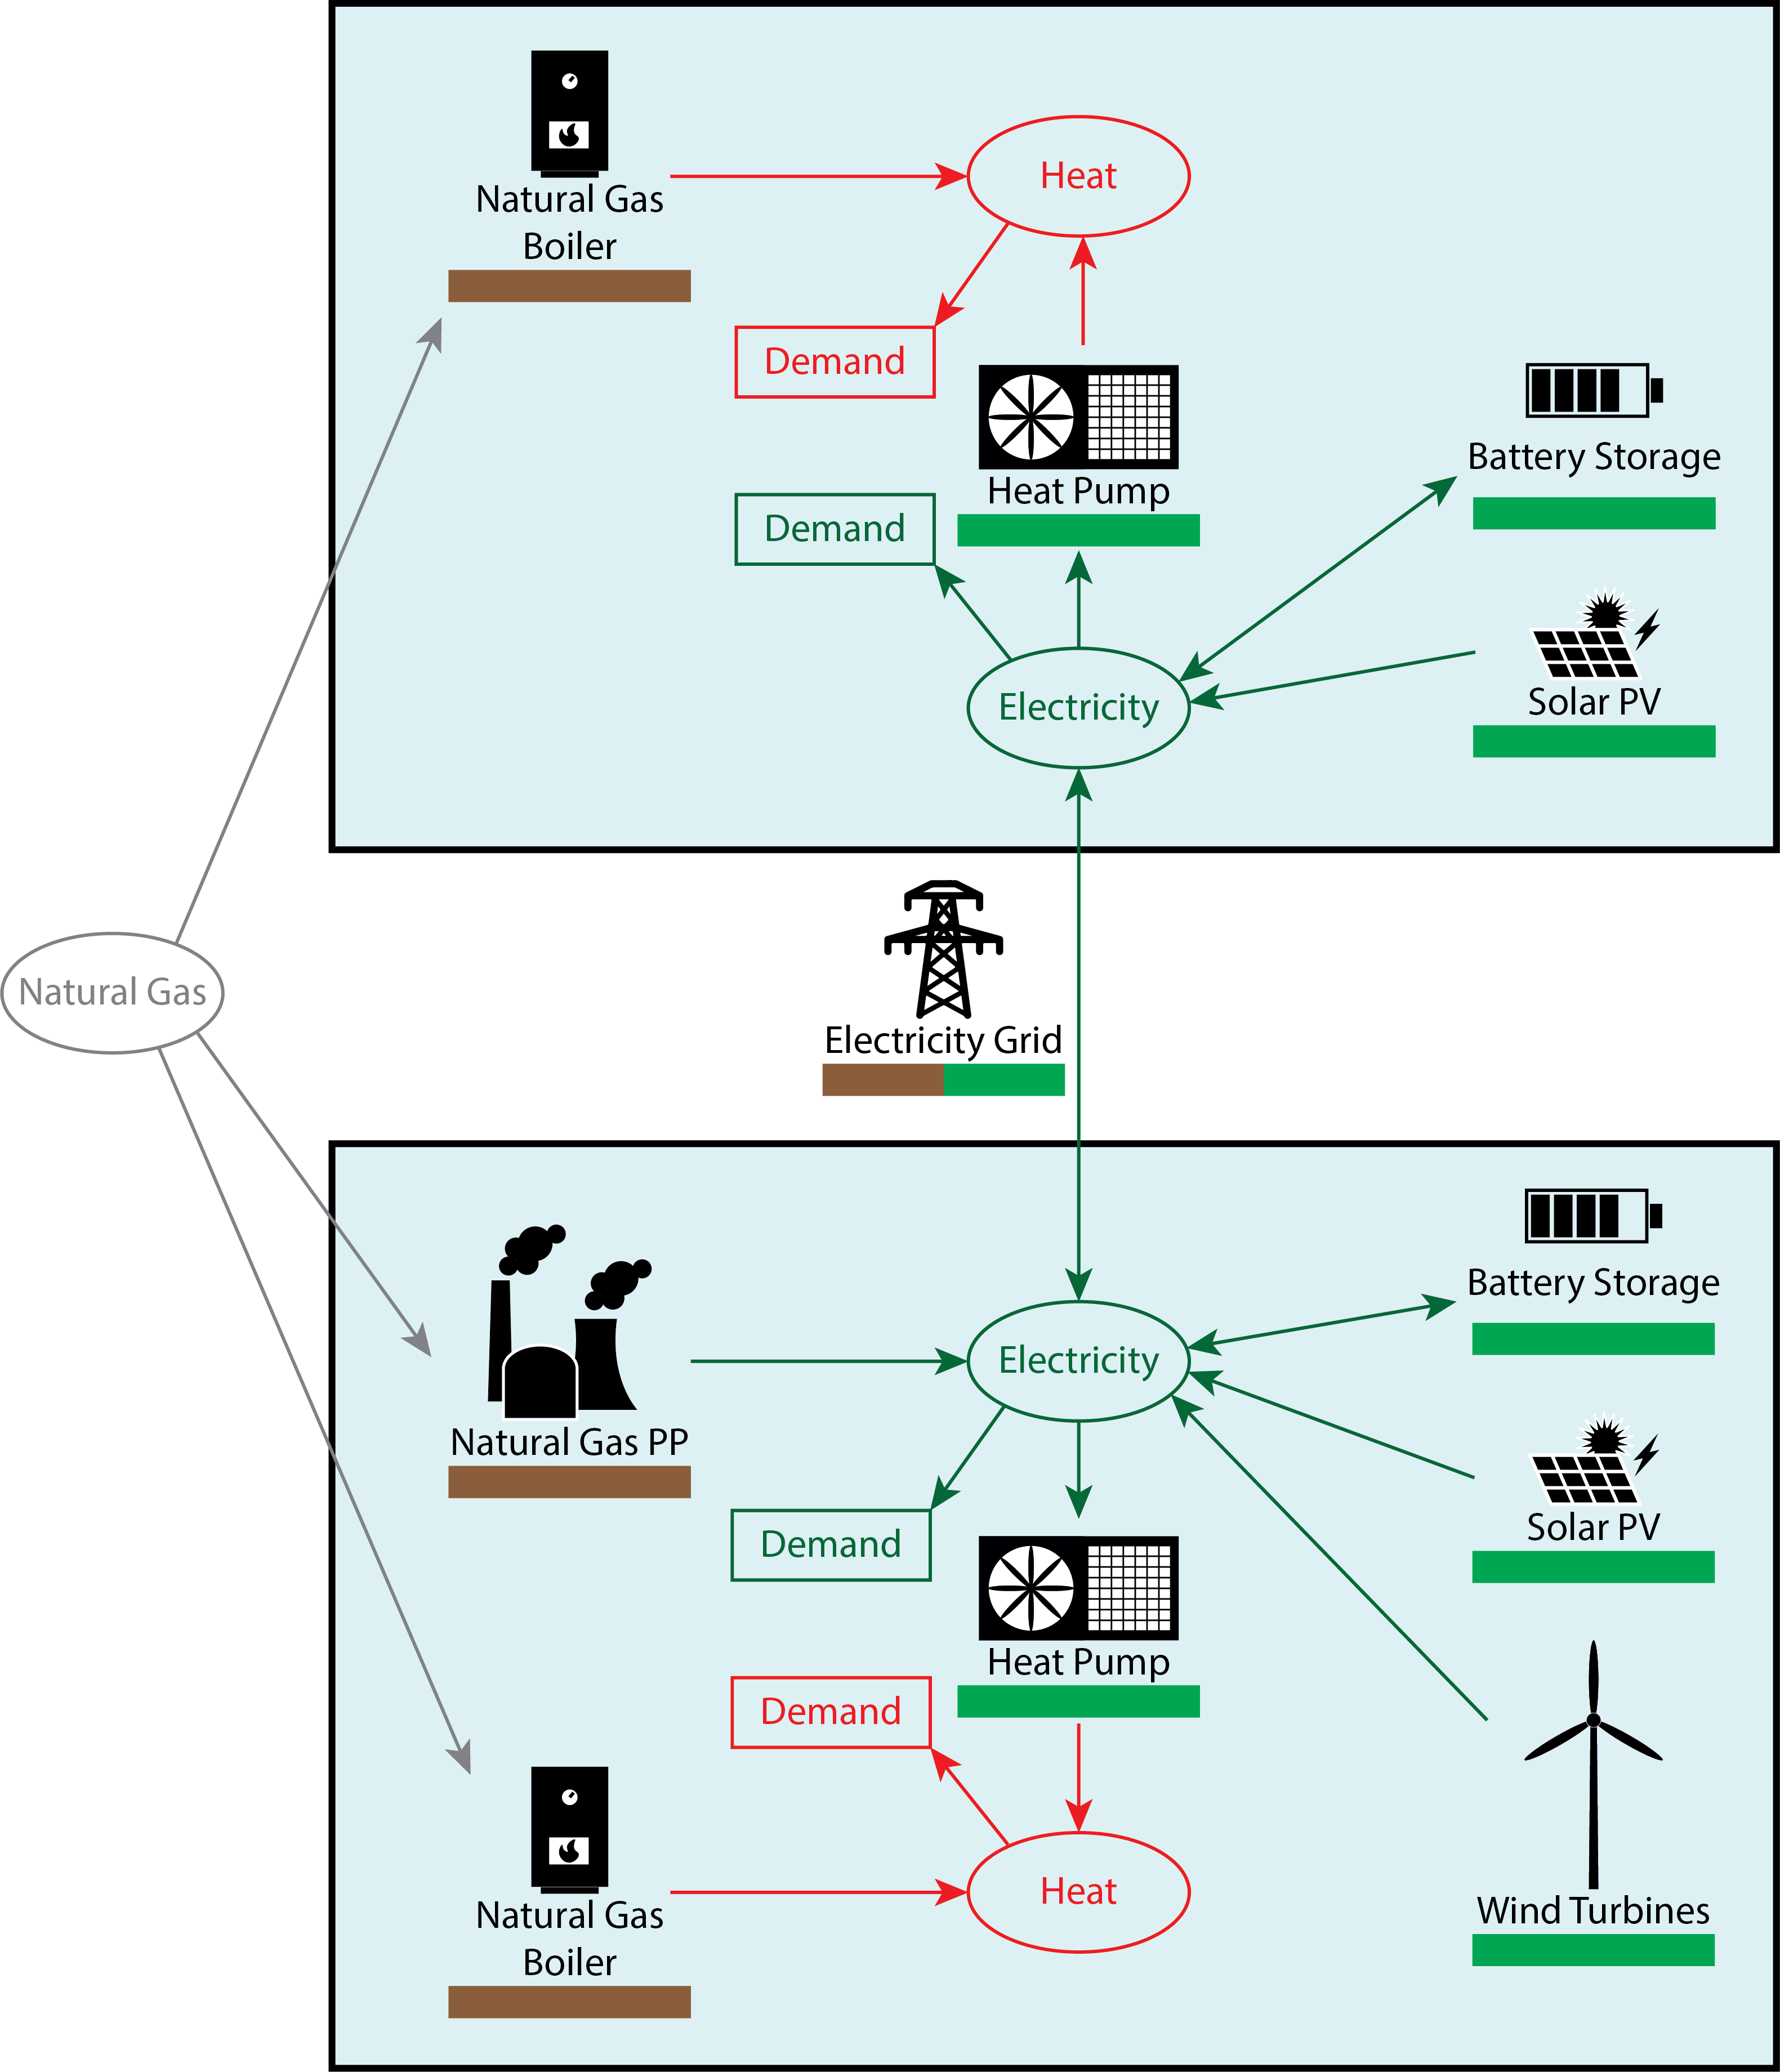
</div>

## Create templates
We set the input data path and in this directory we can add input data templates for the model configuration and the topology with the function create_optimization_templates.


In [1]:
import adopt_net0 as adopt
import json
from pathlib import Path
import os
import pandas as pd
import numpy as np

input_data_path = Path("./caseStudies/network")
adopt.create_optimization_templates(input_data_path)

Files already exist: caseStudies\network\Topology.json caseStudies\network\ConfigModel.json


## Adapt Topology
We need to adapt the topology as well as the model configuration file to our case study. This can be done either in the file itself (Topology.json) or, as we do it here via some lines of code.
For the topology, we need to change the following:
- Change nodes: city and urban area
- Change carriers: electricity, heat and natural gas (we need to add hydrogen as a carrier as well, as the gas turbine also allows for a hydrogen input, even though we do not use it in this case study)
- Change investment periods: period1
- The options regarding the time frame we can leave at the default (one year with hourly operation)

In [2]:
# Load json template
with open(input_data_path / "Topology.json", "r") as json_file:
    topology = json.load(json_file)
# Nodes
topology["nodes"] = ["city", "rural"]
# Carriers:
topology["carriers"] = ["electricity", "heat", "gas", "hydrogen"]
# Investment periods:
topology["investment_periods"] = ["period1"]
# Save json template
with open(input_data_path / "Topology.json", "w") as json_file:
    json.dump(topology, json_file, indent=4)

## Adapt Model Configurations
The model configuration we leave as it is, except spcifying a number of typical days to speed up the optimization (this system also solves on full resolution, but here, we want to only show how the model works at the expense of precision). Additionally, we set the MILP gap to 2%.
- Change the number of typical days to 30 and select time aggregation method 1
- Change the MILP gap to 2%

In [3]:
# Load json template
with open(input_data_path / "ConfigModel.json", "r") as json_file:
    configuration = json.load(json_file)
# Set time aggregation settings:
configuration["optimization"]["typicaldays"]["N"]["value"] = 30
configuration["optimization"]["typicaldays"]["method"]["value"] = 1
# Set MILP gap
configuration["solveroptions"]["mipgap"]["value"] = 0.02
# Save json template
with open(input_data_path / "ConfigModel.json", "w") as json_file:
    json.dump(configuration, json_file, indent=4)

## Define new and existing technologies at each node
First, we create the required folder structure based on the Topology.json file and we can show all available technologies as follows:

In [4]:
adopt.create_input_data_folder_template(input_data_path)
adopt.show_available_technologies()

MEA_large
MEA_medium
MEA_small
DAC_Adsorption
dac_adsorption_performanc
Boiler_El
Boiler_Industrial_NG
Boiler_Small_H2
Boiler_Small_NG
Furnace_H2
Furnace_NG
HeatPump_AirSourced
HeatPump_GroundSourced
HeatPump_WaterSourced
Hydro_Reservoir
PumpedHydro_Closed
PumpedHydro_Open
CrackerFurnace
CrackerFurnace_Electric
EthyleneCompression
EthyleneCompression_Electric
EthyleneSeparation
SteamReformer
SteamReformer_CCS
GasTurbine_H2_10
GasTurbine_H2_100
GasTurbine_H2_250
GasTurbine_H2_400
GasTurbine_NG_10
GasTurbine_NG_100
GasTurbine_NG_250
GasTurbine_NG_400
GasTurbine_simple
GasTurbine_simple_CCS
SteamTurbine
Photovoltaic
SolarThermal
WindTurbine_Offshore_11000
WindTurbine_Offshore_6000
WindTurbine_Offshore_9500
WindTurbine_Onshore_1500
WindTurbine_Onshore_2500
WindTurbine_Onshore_4000
WT_dat
PermanentStorage_CO2_simple
Storage_Battery
Storage_Ethylene
Storage_H2
Storage_H2_Cavern
Storage_HotWater
Storage_NG
Storage_PCM
TemporaryStorage_CO2


... And we can add the technologies that we need to the Technologies.json file at the respective nodes and copy over the required technology data

In [5]:
# Add required technologies for node 'city'
with open(input_data_path / "period1" / "node_data" / "city" / "Technologies.json", "r") as json_file:
    technologies = json.load(json_file)
technologies["new"] = ["HeatPump_AirSourced", "Storage_Battery", "Photovoltaic"]
technologies["existing"] = {"Boiler_Small_NG": 1000}

with open(input_data_path / "period1" / "node_data" / "city" / "Technologies.json", "w") as json_file:
    json.dump(technologies, json_file, indent=4)

# Add required technologies for node 'rural'
with open(input_data_path / "period1" / "node_data" / "rural" / "Technologies.json", "r") as json_file:
    technologies = json.load(json_file)
technologies["new"] = ["HeatPump_AirSourced", "Storage_Battery", "Photovoltaic", "WindTurbine_Onshore_4000"]
technologies["existing"] = {"Boiler_Small_NG": 350, "GasTurbine_simple": 1000}

with open(input_data_path / "period1" / "node_data" / "rural" / "Technologies.json", "w") as json_file:
    json.dump(technologies, json_file, indent=4)

# Copy over technology files
adopt.copy_technology_data(input_data_path)

## Change maximum sizes of heat pumps and boilers
As these technologies are by default set to a household level, we need to change the maximum sizes to make them suitable to meet a larger energy demand

In [6]:
for node in ["city", "rural"]:
    with open(input_data_path / "period1" / "node_data" / node / "technology_data"/ "Boiler_Small_NG.json", "r") as json_file:
        tec_data = json.load(json_file)
        tec_data["size_max"] = 2000

    with open(input_data_path / "period1"  /  "node_data" /node / "technology_data"/ "Boiler_Small_NG.json", "w") as json_file:
        json.dump(tec_data, json_file, indent=4)
    
    with open(input_data_path / "period1" /  "node_data" / node / "technology_data"/ "HeatPump_AirSourced.json", "r") as json_file:
        tec_data = json.load(json_file)
        tec_data["size_max"] = 3000
    with open(input_data_path / "period1" /  "node_data" / node / "technology_data"/ "HeatPump_AirSourced.json", "w") as json_file:
        json.dump(tec_data, json_file, indent=4)
 

## Define the existing and new electricity network between the two nodes
We can see available networks that ship with the model with:

In [7]:
adopt.show_available_networks()

CO2PipelineOffshore
CO2PipelineOnshore
CO2Railway
CO2Ship
CO2Truck
electricityOffshore
electricityOnshore
electricitySimple
heat
hydrogenPipelineOffshore
hydrogenPipelineOnshore
hydrogenRailway
hydrogenShip
hydrogenSimple
hydrogenTruck


In this case, we will use 'electricityOnshore' for both the existing and new network:

In [8]:
# Add networks
with open(input_data_path / "period1" / "Networks.json", "r") as json_file:
    networks = json.load(json_file)
networks["new"] = ["electricityOnshore"]
networks["existing"] = ["electricityOnshore"]

with open(input_data_path / "period1" / "Networks.json", "w") as json_file:
    json.dump(networks, json_file, indent=4)

Now we need to specify the network topologies for both the existing and the new network and copy them in the respective directory. This is easier done manually, but here we do it using Python.
New networks need the following files (size_max_arcs is optional):
- connection.csv (1 or 0)
- distance.csv (distance in km): 50km between the two nodes
  
Existing networks need the following files:
- connection.csv (1 or 0)
- distance.csv (distance in km): 50km between the two nodes
- size.csv (size in MW): 1GW connection

In [9]:
# Make a new folder for the existing network
os.makedirs(input_data_path / "period1" / "network_topology" / "existing" / "electricityOnshore", exist_ok=True)

print("Existing network")
# Use the templates, fill and save them to the respective directory
# Connection
connection = pd.read_csv(input_data_path / "period1" / "network_topology" / "existing" / "connection.csv", sep=";", index_col=0)
connection.loc["city", "rural"] = 1
connection.loc["rural", "city"] = 1
connection.to_csv(input_data_path / "period1" / "network_topology" / "existing" / "electricityOnshore" / "connection.csv")
print("Connection:", connection)

# Delete the template
os.remove(input_data_path / "period1" / "network_topology" / "existing" / "connection.csv")

# Distance
distance = pd.read_csv(input_data_path / "period1" / "network_topology" / "existing" / "distance.csv", sep=";", index_col=0)
distance.loc["city", "rural"] = 50
distance.loc["rural", "city"] = 50
distance.to_csv(input_data_path / "period1" / "network_topology" / "existing" / "electricityOnshore" / "distance.csv")
print("Distance:", distance)

# Delete the template
os.remove(input_data_path / "period1" / "network_topology" / "existing" / "distance.csv")

# Size
size = pd.read_csv(input_data_path / "period1" / "network_topology" / "existing" / "size.csv", sep=";", index_col=0)
size.loc["city", "rural"] = 1000
size.loc["rural", "city"] = 1000
size.to_csv(input_data_path / "period1" / "network_topology" / "existing" / "electricityOnshore" / "size.csv")
print("Size:", size)

# Delete the template
os.remove(input_data_path / "period1" / "network_topology" / "existing" / "size.csv")

#TODO: remove these 5 lines after bug fixed
# max size arc existing network
arc_size = pd.read_csv(input_data_path / "period1" / "network_topology" / "new" / "size_max_arcs.csv", sep=";", index_col=0)
arc_size.loc["city", "rural"] = 1000
arc_size.loc["rural", "city"] = 1000
arc_size.to_csv(input_data_path / "period1" / "network_topology" / "existing" / "electricityOnshore" / "size_max_arcs.csv")
print("Max size per arc:", arc_size)



print("New network")
# Make a new folder for the new network
os.makedirs(input_data_path / "period1" / "network_topology" / "new" / "electricityOnshore", exist_ok=True)


# max size arc
arc_size = pd.read_csv(input_data_path / "period1" / "network_topology" / "new" / "size_max_arcs.csv", sep=";", index_col=0)
arc_size.loc["city", "rural"] = 3000
arc_size.loc["rural", "city"] = 3000
arc_size.to_csv(input_data_path / "period1" / "network_topology" / "new" / "electricityOnshore" / "size_max_arcs.csv")
print("Max size per arc:", arc_size)

# Use the templates, fill and save them to the respective directory
# Connection
connection = pd.read_csv(input_data_path / "period1" / "network_topology" / "new" / "connection.csv", sep=";", index_col=0)
connection.loc["city", "rural"] = 1
connection.loc["rural", "city"] = 1
connection.to_csv(input_data_path / "period1" / "network_topology" / "new" / "electricityOnshore" / "connection.csv")
print("Connection:", connection)

# Delete the template
os.remove(input_data_path / "period1" / "network_topology" / "new" / "connection.csv")

# Distance
distance = pd.read_csv(input_data_path / "period1" / "network_topology" / "new" / "distance.csv", sep=";", index_col=0)
distance.loc["city", "rural"] = 50
distance.loc["rural", "city"] = 50
distance.to_csv(input_data_path / "period1" / "network_topology" / "new" / "electricityOnshore" / "distance.csv")
print("Distance:", distance)

# Delete the template
os.remove(input_data_path / "period1" / "network_topology" / "new" / "distance.csv")

# Delete the max_size_arc template
os.remove(input_data_path / "period1" / "network_topology" / "new" / "size_max_arcs.csv")

Existing network
Connection:        city  rural
city      0      1
rural     1      0
Distance:        city  rural
city      0     50
rural    50      0
Size:        city  rural
city      0   1000
rural  1000      0
Max size per arc:        city  rural
city      0   1000
rural  1000      0
New network
Max size per arc:        city  rural
city      0   3000
rural  3000      0
Connection:        city  rural
city      0      1
rural     1      0
Distance:        city  rural
city      0     50
rural    50      0


## Copy over network data
Copy over network data, change cost data and add location of the two nodes

In [10]:
adopt.copy_network_data(input_data_path)

with open(input_data_path / "period1" / "network_data"/ "electricityOnshore.json", "r") as json_file:
    network_data = json.load(json_file)

network_data["Economics"]["gamma2"] = 40000
network_data["Economics"]["gamma4"] = 300

with open(input_data_path / "period1" / "network_data"/ "electricityOnshore.json", "w") as json_file:
    json.dump(network_data, json_file, indent=4)

node_location = pd.read_csv(input_data_path / "NodeLocations.csv", sep=';', index_col=0, header=0)
node_lon = {'city': 4.9, 'rural': 5.1}
node_lat = {'city': 52.0, 'rural': 52.2}
node_alt = {'city': 10, 'rural': 15}
for node in ['city', 'rural']:
    node_location.at[node, 'lon'] = node_lon[node]
    node_location.at[node, 'lat'] = node_lat[node]
    node_location.at[node, 'alt'] = node_alt[node]

node_location = node_location.reset_index()
node_location.to_csv(input_data_path / "NodeLocations.csv", sep=';', index=False)

## Define demand, climate data, import limits, import prices

In [11]:
# Read hourly data from Excel
user_input_rural_path = "./caseStudies/data/data_network_rural.xlsx"
rural_hourly_data = pd.read_excel(user_input_rural_path, header=0, nrows=8760)
user_input_city_path = "./caseStudies/data/data_network_city.xlsx"
city_hourly_data = pd.read_excel(user_input_city_path, header=0, nrows=8760)

# Save the hourly data to the carrier's file in the case study folder
# electricity demand and price
hourly_data = {
    'city': city_hourly_data,
    'rural': rural_hourly_data
}

el_demand = {}
heat_demand = {}

for node in ['city', 'rural']:
    el_demand[node] = hourly_data[node].iloc[:, 1]
    heat_demand[node] = hourly_data[node].iloc[:, 0]
    adopt.fill_carrier_data(input_data_path, value_or_data=el_demand[node], columns=['Demand'], carriers=['electricity'], nodes=[node])
    adopt.fill_carrier_data(input_data_path, value_or_data=heat_demand[node], columns=['Demand'], carriers=['heat'], nodes=[node])

    # Set import limits/cost
    adopt.fill_carrier_data(input_data_path, value_or_data=4000, columns=['Import limit'], carriers=['gas'], nodes=[node])
    adopt.fill_carrier_data(input_data_path, value_or_data=2000, columns=['Import limit'], carriers=['electricity'], nodes=[node])
    adopt.fill_carrier_data(input_data_path, value_or_data=0.25, columns=['Import emission factor'], carriers=['electricity'], nodes=[node])
    adopt.fill_carrier_data(input_data_path, value_or_data=40, columns=['Import price'], carriers=['gas'], nodes=[node])
    adopt.fill_carrier_data(input_data_path, value_or_data=120, columns=['Import price'], carriers=['electricity'], nodes=[node])

# Define climate data
adopt.load_climate_data_from_api(input_data_path)

Importing Climate Data...
Importing Climate Data successful
Importing Climate Data...
Importing Climate Data successful


## Run without carbon costs

In [12]:
m = adopt.ModelHub()
m.read_data(input_data_path)
m.quick_solve()

INFO:--- Reading in data ---
INFO:Input data folder has been checked successfully - no errors occurred.
INFO:Topology read successfully
INFO:Model Configuration read successfully
INFO:Model Configuration used: {"optimization": {"objective": {"description": "String specifying the objective/type of optimization.", "options": ["costs", "emissions_pos", "emissions_net", "emissions_minC", "costs_emissionlimit", "pareto"], "value": "costs"}, "emission_limit": {"description": "emission limit to be enforced if objective function is costs_emissionlimit", "value": 0}, "monte_carlo": {"N": {"description": "Number of Monte Carlo simulations (0 = off).", "value": 0}, "type": {"description": "Type of Monte Carlo simulation. For type 1 the user defines the standard deviation and the components to vary. For type 2 the user provides a csv file with the parameters and their min, max and reference values. ", "options": ["normal_dis", "uniform_dis_from_file"], "value": "normal_dis"}, "sd": {"description":

--- Reading in data ---
Input data folder has been checked successfully - no errors occurred.
Topology read successfully
Model Configuration read successfully
Found NaN values in data for investment period period1, node city, key1 CarbonCost, carrier global, key2 price. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarbonCost, carrier global, key2 subsidy. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 ClimateData, carrier global, key2 TECHNOLOGYNAME_hydro_inflow. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Export price. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Export emissio

INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Generic production. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier gas, key2 De

Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import limit. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import price. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export price. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Generic production. Replaced with zeros.


INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier gas, key2 Export limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier gas, key2 Export price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier gas, key2 Import emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier gas, key2 Export emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier gas, key2 Generic production. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier hydrogen, key2 Demand. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier hydrogen, key2 Impo

Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier gas, key2 Demand. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier gas, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier gas, key2 Export price. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier gas, key2 Import emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier gas, key2 Export emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier gas, key2 Generic production. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier hydrogen, key2 Demand. Replaced with zeros.
Found NaN value

INFO:Found NaN values in data for investment period period1, node rural, key1 ClimateData, carrier global, key2 TECHNOLOGYNAME_hydro_inflow. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export limit. Replaced with zeros.


Found NaN values in data for investment period period1, node rural, key1 ClimateData, carrier global, key2 TECHNOLOGYNAME_hydro_inflow. Replaced with zeros.


INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Generic production. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Import limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Export limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Import price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, ca

Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export price. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Generic production. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Import limit. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Import pric

INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Import limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Export limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Import price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Export price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Import emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Export emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierD

Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Demand. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Import limit. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Import price. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Export price. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Import emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Export emission factor.

INFO:Time series read successfully
INFO:Node Locations read successfully
INFO:Energy balance options read successfully


Time series read successfully
Node Locations read successfully
Energy balance options read successfully
Deriving performance data for Heat Pump...
Complete:  99.0 %Complete:  100 %
Deriving performance data for Heat Pump...
Complete:  99.0 %Complete:  100 %


C:\Users\6574114\PycharmProjects\adopt_net0\adopt_net0\components\technologies\genericTechnologies\res.py:202: UserWarning: TurbineName not in csv, standard WindTurbine_Onshore_1500 selected.
  warnings.warn(
INFO:Technology data read successfully
INFO:Network data read successfully


Technology data read successfully
Network data read successfully


INFO:Clustered data successfully
INFO:--- Reading in data complete ---
INFO:--- Constructing Model ---
INFO:Constructing Investment Period period1
INFO:Constructing Investment Period period1 completed
INFO:	 - Constructing Network electricityOnshore
INFO:	 - Constructing Network electricityOnshore completed
INFO:			gdp.bigm Transformation...
INFO:			gdp.bigm Transformation completed in 0 s
INFO:	 - Constructing Network electricityOnshore_existing
INFO:	 - Constructing Network electricityOnshore_existing completed
INFO:			gdp.bigm Transformation...
INFO:			gdp.bigm Transformation completed in 0 s


Clustered data successfully
--- Reading in data complete ---
--- Constructing Model ---
Constructing Investment Period period1
	 - Constructing Network electricityOnshore
			gdp.bigm Transformation...
	 - Constructing Network electricityOnshore_existing
			gdp.bigm Transformation...


INFO:	 - Adding Technology HeatPump_AirSourced
INFO:	 - Adding Technology Storage_Battery


	 - Adding Technology HeatPump_AirSourced
	 - Adding Technology Storage_Battery


INFO:			gdp.bigm Transformation...


			gdp.bigm Transformation...


INFO:			gdp.bigm Transformation completed in 0 s
INFO:	 - Adding Technology Photovoltaic


	 - Adding Technology Photovoltaic


position is deprecated.  Please use at()  (deprecated in 6.1, will be
removed in (or after) 7.0)
(called from C:\Users\6574114\PycharmProjects\adopt_net0\adopt_net0\components\technologies\technology.py:905)
INFO:	 - Adding Technology Boiler_Small_NG
INFO:	 - Adding Technology HeatPump_AirSourced


	 - Adding Technology Boiler_Small_NG
	 - Adding Technology HeatPump_AirSourced


INFO:	 - Adding Technology Storage_Battery


	 - Adding Technology Storage_Battery


INFO:			gdp.bigm Transformation...


			gdp.bigm Transformation...


INFO:			gdp.bigm Transformation completed in 0 s
INFO:	 - Adding Technology Photovoltaic
INFO:	 - Adding Technology WindTurbine_Onshore_4000
INFO:	 - Adding Technology Boiler_Small_NG


	 - Adding Technology Photovoltaic
	 - Adding Technology WindTurbine_Onshore_4000


INFO:	 - Adding Technology GasTurbine_simple
INFO:Constructing model completed in 3s
INFO:Constructing balances...


	 - Adding Technology Boiler_Small_NG
	 - Adding Technology GasTurbine_simple
Constructing model completed in 3s
Constructing balances...


INFO:Constructing balances completed in 1s
INFO:Set objective on cost
INFO:Set parameter Username
INFO:Academic license - for non-commercial use only - expires 2025-04-29


Constructing balances completed in 1s
Set objective on cost
____________________________________________________________
Solving Model...
Set parameter LogFile to value "userData\20240621174002-1\solver_log.txt"


INFO:Set parameter LogFile to value "userData\20240621174002-1\solver_log.txt"


Solver log file: userData\20240621174002-1\solver_log.txt
Set parameter TimeLimit to value 36000


INFO:Set parameter TimeLimit to value 36000


Set parameter MIPGap to value 0.02


INFO:Set parameter MIPGap to value 0.02


Set parameter NodefileStart to value 60


INFO:Set parameter NodefileStart to value 60


Set parameter LPWarmStart to value 0


INFO:Set parameter LPWarmStart to value 0


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


INFO:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


INFO:


CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]


INFO:CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]


Thread count: 10 physical cores, 12 logical processors, using up to 12 threads


INFO:Thread count: 10 physical cores, 12 logical processors, using up to 12 threads


INFO:


Optimize a model with 151755 rows, 134242 columns and 357216 nonzeros


INFO:Optimize a model with 151755 rows, 134242 columns and 357216 nonzeros


Model fingerprint: 0xb06d07f2


INFO:Model fingerprint: 0xb06d07f2


Variable types: 130641 continuous, 3601 integer (2880 binary)


INFO:Variable types: 130641 continuous, 3601 integer (2880 binary)


Coefficient statistics:


INFO:Coefficient statistics:


  Matrix range     [5e-05, 3e+06]


INFO:  Matrix range     [5e-05, 3e+06]


  Objective range  [1e+00, 1e+00]


INFO:  Objective range  [1e+00, 1e+00]


  Bounds range     [5e-02, 8e+11]


INFO:  Bounds range     [5e-02, 8e+11]


  RHS range        [1e+00, 3e+07]


INFO:  RHS range        [1e+00, 3e+07]


INFO:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:         to avoid numerical issues.


Presolve removed 128147 rows and 120110 columns


INFO:Presolve removed 128147 rows and 120110 columns


Presolve time: 0.95s


INFO:Presolve time: 0.95s


Presolved: 23608 rows, 14132 columns, 68664 nonzeros


INFO:Presolved: 23608 rows, 14132 columns, 68664 nonzeros


Variable types: 12691 continuous, 1441 integer (720 binary)


INFO:Variable types: 12691 continuous, 1441 integer (720 binary)


Found heuristic solution: objective 7.626319e+08


INFO:Found heuristic solution: objective 7.626319e+08


INFO:


Root relaxation: cutoff, 7929 iterations, 0.28 seconds (0.37 work units)


INFO:Root relaxation: cutoff, 7929 iterations, 0.28 seconds (0.37 work units)


INFO:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:


     0     0     cutoff    0      7.6263e+08 7.6263e+08  0.00%     -    1s


INFO:     0     0     cutoff    0      7.6263e+08 7.6263e+08  0.00%     -    1s


INFO:


Explored 1 nodes (7929 simplex iterations) in 1.67 seconds (2.10 work units)


INFO:Explored 1 nodes (7929 simplex iterations) in 1.67 seconds (2.10 work units)


Thread count was 12 (of 12 available processors)


INFO:Thread count was 12 (of 12 available processors)


INFO:


Solution count 2: 7.62632e+08 7.62632e+08 


INFO:Solution count 2: 7.62632e+08 7.62632e+08 


INFO:


Optimal solution found (tolerance 2.00e-02)


INFO:Optimal solution found (tolerance 2.00e-02)


INFO:Warning: max constraint violation (1.3910e-06) exceeds tolerance


Best objective 7.626319357676e+08, best bound 7.626319357676e+08, gap 0.0000%


INFO:Best objective 7.626319357676e+08, best bound 7.626319357676e+08, gap 0.0000%


Set parameter LogFile to value ""


INFO:Set parameter LogFile to value ""
INFO:Writing results to userData\20240621174002-1


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 762631935.7676208
  Upper bound: 762631935.7676208
  Number of objectives: 1
  Number of constraints: 151755
  Number of variables: 134242
  Number of binary variables: 2880
  Number of integer variables: 3601
  Number of continuous variables: 127761
  Number of nonzeros: 357216
  Sense: minimize
  Number of solutions: 2
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Name: Gurobi 11.02
  Status: ok
  Wallclock time: 1.686000108718872
  Termination condition: optimal
  Termination message: Model was solved to optimal

## Run with carbon costs

In [13]:
# Set carbon emission price
carbon_price = np.ones(8760)*98
for node in ["city", "rural"]:
    carbon_cost_path = "./caseStudies/network/period1/node_data/" + node + "/CarbonCost.csv"
    carbon_cost_template = pd.read_csv(carbon_cost_path, sep=';', index_col=0, header=0)
    carbon_cost_template['price'] = carbon_price
    carbon_cost_template = carbon_cost_template.reset_index()
    carbon_cost_template.to_csv(carbon_cost_path, sep=';', index=False)

m = adopt.ModelHub()
m.read_data(input_data_path)
m.quick_solve()

INFO:--- Reading in data ---
INFO:Input data folder has been checked successfully - no errors occurred.
INFO:Topology read successfully
INFO:Model Configuration read successfully
INFO:Model Configuration used: {"optimization": {"objective": {"description": "String specifying the objective/type of optimization.", "options": ["costs", "emissions_pos", "emissions_net", "emissions_minC", "costs_emissionlimit", "pareto"], "value": "costs"}, "emission_limit": {"description": "emission limit to be enforced if objective function is costs_emissionlimit", "value": 0}, "monte_carlo": {"N": {"description": "Number of Monte Carlo simulations (0 = off).", "value": 0}, "type": {"description": "Type of Monte Carlo simulation. For type 1 the user defines the standard deviation and the components to vary. For type 2 the user provides a csv file with the parameters and their min, max and reference values. ", "options": ["normal_dis", "uniform_dis_from_file"], "value": "normal_dis"}, "sd": {"description":

--- Reading in data ---
Input data folder has been checked successfully - no errors occurred.
Topology read successfully
Model Configuration read successfully
Found NaN values in data for investment period period1, node city, key1 CarbonCost, carrier global, key2 subsidy. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 ClimateData, carrier global, key2 TECHNOLOGYNAME_hydro_inflow. Replaced with zeros.


INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Export limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Export price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Export emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Generic production. Replaced with zeros.


Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Export price. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Export emission factor. Replaced with zeros.


INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Generic

Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Generic production. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import limit. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import price. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export price. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export emission factor. Replaced with z

INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier hydrogen, key2 Export emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier hydrogen, key2 Generic production. Replaced with zeros.


Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier hydrogen, key2 Import emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier hydrogen, key2 Export emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier hydrogen, key2 Generic production. Replaced with zeros.


INFO:Found NaN values in data for investment period period1, node rural, key1 CarbonCost, carrier global, key2 subsidy. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 ClimateData, carrier global, key2 TECHNOLOGYNAME_hydro_inflow. Replaced with zeros.


Found NaN values in data for investment period period1, node rural, key1 CarbonCost, carrier global, key2 subsidy. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 ClimateData, carrier global, key2 TECHNOLOGYNAME_hydro_inflow. Replaced with zeros.


INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Generic production. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Import limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Export limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierD

Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export price. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Generic production. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Import limit. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Import pric

INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Export limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Export price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Import emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Export emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Generic production. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Demand. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, ke

Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Demand. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Export price. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Import emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Export emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Generic production. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Demand. Replaced with zeros.
Found Na

INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Export emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Generic production. Replaced with zeros.
INFO:Time series read successfully
INFO:Node Locations read successfully
INFO:Energy balance options read successfully


Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Export emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Generic production. Replaced with zeros.
Time series read successfully
Node Locations read successfully
Energy balance options read successfully
Deriving performance data for Heat Pump...
Complete:  99.0 %Complete:  100 %
Deriving performance data for Heat Pump...
Complete:  99.0 %Complete:  100 %


C:\Users\6574114\PycharmProjects\adopt_net0\adopt_net0\components\technologies\genericTechnologies\res.py:202: UserWarning: TurbineName not in csv, standard WindTurbine_Onshore_1500 selected.
  warnings.warn(
INFO:Technology data read successfully
INFO:Network data read successfully


Technology data read successfully
Network data read successfully


INFO:Clustered data successfully
INFO:--- Reading in data complete ---
INFO:--- Constructing Model ---
INFO:Constructing Investment Period period1
INFO:Constructing Investment Period period1 completed
INFO:	 - Constructing Network electricityOnshore
INFO:	 - Constructing Network electricityOnshore completed
INFO:			gdp.bigm Transformation...
INFO:			gdp.bigm Transformation completed in 0 s
INFO:	 - Constructing Network electricityOnshore_existing
INFO:	 - Constructing Network electricityOnshore_existing completed
INFO:			gdp.bigm Transformation...
INFO:			gdp.bigm Transformation completed in 0 s
INFO:	 - Adding Technology HeatPump_AirSourced
INFO:	 - Adding Technology Storage_Battery


Clustered data successfully
--- Reading in data complete ---
--- Constructing Model ---
Constructing Investment Period period1
	 - Constructing Network electricityOnshore
			gdp.bigm Transformation...
	 - Constructing Network electricityOnshore_existing
			gdp.bigm Transformation...
	 - Adding Technology HeatPump_AirSourced
	 - Adding Technology Storage_Battery


INFO:			gdp.bigm Transformation...


			gdp.bigm Transformation...


INFO:			gdp.bigm Transformation completed in 0 s
INFO:	 - Adding Technology Photovoltaic


	 - Adding Technology Photovoltaic


INFO:	 - Adding Technology Boiler_Small_NG
INFO:	 - Adding Technology HeatPump_AirSourced


	 - Adding Technology Boiler_Small_NG
	 - Adding Technology HeatPump_AirSourced


INFO:	 - Adding Technology Storage_Battery


	 - Adding Technology Storage_Battery


INFO:			gdp.bigm Transformation...


			gdp.bigm Transformation...


INFO:			gdp.bigm Transformation completed in 0 s
INFO:	 - Adding Technology Photovoltaic
INFO:	 - Adding Technology WindTurbine_Onshore_4000
INFO:	 - Adding Technology Boiler_Small_NG


	 - Adding Technology Photovoltaic
	 - Adding Technology WindTurbine_Onshore_4000


INFO:	 - Adding Technology GasTurbine_simple
INFO:Constructing model completed in 4s
INFO:Constructing balances...


	 - Adding Technology Boiler_Small_NG
	 - Adding Technology GasTurbine_simple
Constructing model completed in 4s
Constructing balances...


INFO:Constructing balances completed in 1s
INFO:Set objective on cost


Constructing balances completed in 1s
Set objective on cost
____________________________________________________________
Solving Model...
Set parameter LogFile to value "userData\20240621174024-1\solver_log.txt"


INFO:Set parameter LogFile to value "userData\20240621174024-1\solver_log.txt"


Solver log file: userData\20240621174024-1\solver_log.txt
Set parameter TimeLimit to value 36000


INFO:Set parameter TimeLimit to value 36000


Set parameter MIPGap to value 0.02


INFO:Set parameter MIPGap to value 0.02


Set parameter NodefileStart to value 60


INFO:Set parameter NodefileStart to value 60


Set parameter LPWarmStart to value 0


INFO:Set parameter LPWarmStart to value 0


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


INFO:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


INFO:


CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]


INFO:CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]


Thread count: 10 physical cores, 12 logical processors, using up to 12 threads


INFO:Thread count: 10 physical cores, 12 logical processors, using up to 12 threads


INFO:


Optimize a model with 151755 rows, 134242 columns and 368736 nonzeros


INFO:Optimize a model with 151755 rows, 134242 columns and 368736 nonzeros


Model fingerprint: 0x9c85f045


INFO:Model fingerprint: 0x9c85f045


Variable types: 130641 continuous, 3601 integer (2880 binary)


INFO:Variable types: 130641 continuous, 3601 integer (2880 binary)


Coefficient statistics:


INFO:Coefficient statistics:


  Matrix range     [6e-05, 3e+06]


INFO:  Matrix range     [6e-05, 3e+06]


  Objective range  [1e+00, 1e+00]


INFO:  Objective range  [1e+00, 1e+00]


  Bounds range     [6e-02, 8e+11]


INFO:  Bounds range     [6e-02, 8e+11]


  RHS range        [1e+00, 3e+07]


INFO:  RHS range        [1e+00, 3e+07]


INFO:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:         to avoid numerical issues.


Presolve removed 128147 rows and 120110 columns


INFO:Presolve removed 128147 rows and 120110 columns


Presolve time: 1.05s


INFO:Presolve time: 1.05s


Presolved: 23608 rows, 14132 columns, 68664 nonzeros


INFO:Presolved: 23608 rows, 14132 columns, 68664 nonzeros


Variable types: 12691 continuous, 1441 integer (720 binary)


INFO:Variable types: 12691 continuous, 1441 integer (720 binary)


Found heuristic solution: objective 1.070600e+09


INFO:Found heuristic solution: objective 1.070600e+09


INFO:


Root relaxation: objective 1.036362e+09, 9209 iterations, 0.49 seconds (0.55 work units)


INFO:Root relaxation: objective 1.036362e+09, 9209 iterations, 0.49 seconds (0.55 work units)


INFO:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:


     0     0 1.0364e+09    0  721 1.0706e+09 1.0364e+09  3.20%     -    2s


INFO:     0     0 1.0364e+09    0  721 1.0706e+09 1.0364e+09  3.20%     -    2s


     0     0 1.0364e+09    0  720 1.0706e+09 1.0364e+09  3.20%     -    2s


INFO:     0     0 1.0364e+09    0  720 1.0706e+09 1.0364e+09  3.20%     -    2s


H    0     0                    1.036393e+09 1.0364e+09  0.00%     -    2s


INFO:H    0     0                    1.036393e+09 1.0364e+09  0.00%     -    2s


INFO:


Cutting planes:


INFO:Cutting planes:


  Gomory: 4


INFO:  Gomory: 4


  MIR: 22


INFO:  MIR: 22


INFO:


Explored 1 nodes (12600 simplex iterations) in 2.80 seconds (2.98 work units)


INFO:Explored 1 nodes (12600 simplex iterations) in 2.80 seconds (2.98 work units)


Thread count was 12 (of 12 available processors)


INFO:Thread count was 12 (of 12 available processors)


INFO:


Solution count 2: 1.03639e+09 1.0706e+09 


INFO:Solution count 2: 1.03639e+09 1.0706e+09 


INFO:


Optimal solution found (tolerance 2.00e-02)


INFO:Optimal solution found (tolerance 2.00e-02)


Best objective 1.036393194042e+09, best bound 1.036380064133e+09, gap 0.0013%


INFO:Best objective 1.036393194042e+09, best bound 1.036380064133e+09, gap 0.0013%


Set parameter LogFile to value ""


INFO:Set parameter LogFile to value ""
INFO:Writing results to userData\20240621174024-1


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1036380064.1327778
  Upper bound: 1036393194.0417098
  Number of objectives: 1
  Number of constraints: 151755
  Number of variables: 134242
  Number of binary variables: 2880
  Number of integer variables: 3601
  Number of continuous variables: 127761
  Number of nonzeros: 368736
  Sense: minimize
  Number of solutions: 2
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Name: Gurobi 11.02
  Status: ok
  Wallclock time: 2.807999849319458
  Termination condition: optimal
  Termination message: Model was solved to optim